# EDA and Pre-processing

The purpose of the **EDA and Preprocessing** notebook is to understand, clean, and prepare the raw stock market data before applying any machine learning models.
Through **Exploratory Data Analysis (EDA)**, I explore data patterns, trends, and anomalies to gain insights into how stock prices behave over time.
**Preprocessing** ensures the dataset is consistent, complete, and structured — by handling missing values, scaling numerical features, and creating time-based sequences.
Spending time on this step is crucial because high-quality, well-prepared data directly improves model performance, reduces errors, and helps the Transformer learn meaningful temporal relationships rather than being misled by noise or formatting issues.


In [7]:
import pandas as pd
import os
import kagglehub

# Step 1 — Download dataset
root = kagglehub.dataset_download("paultimothymooney/stock-market-data")
print("Dataset root:", root)

# Step 2 — Locate the nasdaq/csv folder
nasdaq_csv_dir = None
for r, dirs, files in os.walk(root):
    if os.path.basename(r).lower() == "csv" and "nasdaq" in r.lower():
        nasdaq_csv_dir = r
        break

if nasdaq_csv_dir is None:
    raise FileNotFoundError("Couldn't find the 'nasdaq/csv' directory in the dataset.")

print(" Found NASDAQ CSV directory:", nasdaq_csv_dir)

# Step 3 — List available tickers
tickers = sorted([f for f in os.listdir(nasdaq_csv_dir) if f.endswith(".csv")])
print(f"Total tickers available: {len(tickers)}")
print("Example tickers:", tickers[:10])

# Step 4 — Pick the first available ticker (you can replace with another)
ticker_file = tickers[0]  # e.g., 'AAPL.csv' may not exist, so load first one instead
file_path = os.path.join(nasdaq_csv_dir, ticker_file)
print(" Loading:", ticker_file)

# Step 5 — Load and inspect data
df = pd.read_csv(file_path)
print(df.head())
print(df.info())


Using Colab cache for faster access to the 'stock-market-data' dataset.
Dataset root: /kaggle/input/stock-market-data
 Found NASDAQ CSV directory: /kaggle/input/stock-market-data/stock_market_data/nasdaq/csv
Total tickers available: 1564
Example tickers: ['AAL.csv', 'AAME.csv', 'AAOI.csv', 'AAON.csv', 'AAPL.csv', 'AAVL.csv', 'AAWW.csv', 'ABCB.csv', 'ABCD.csv', 'ABCO.csv']
 Loading: AAL.csv
         Date        Low       Open   Volume       High      Close  \
0  27-09-2005  19.100000  21.049999   961200  21.400000  19.299999   
1  28-09-2005  19.200001  19.299999  5747900  20.530001  20.500000   
2  29-09-2005  20.100000  20.400000  1078200  20.580000  20.209999   
3  30-09-2005  20.180000  20.260000  3123300  21.049999  21.010000   
4  03-10-2005  20.900000  20.900000  1057900  21.750000  21.500000   

   Adjusted Close  
0       18.194910  
1       19.326204  
2       19.052805  
3       19.807001  
4       20.268940  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 

# Pre-processing

Here I am performing preprocessing to clean and prepare the raw stock data for modeling.
This includes converting dates to proper format, sorting chronologically, and handling missing values to maintain continuity.
By keeping only key features like adjusted close price and volume, the data becomes consistent and structured — allowing the model to learn meaningful trends without being affected by noise or irregularities.


In [8]:
# Convert 'Date' column to datetime and sort chronologically
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')

# Forward fill missing values (common in stock data)
df = df.fillna(method='ffill')

# Keep only necessary columns: 'Adjusted Close' instead of 'Close'
# because it's adjusted for dividends and splits (better for modeling)
df = df[['Date', 'Adjusted Close', 'Volume']]

# Rename columns for consistency
df.rename(columns={'Adjusted Close': 'Close'}, inplace=True)

# Set datetime index
df = df.set_index('Date')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Quick preview
print("\nDataFrame info:")
print(df.info())
print("\nSample data:")
print(df.head())


Missing values per column:
Close     0
Volume    0
dtype: int64

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4333 entries, 2005-09-27 to 2022-12-12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4333 non-null   float64
 1   Volume  4333 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 101.6 KB
None

Sample data:
                Close   Volume
Date                          
2005-09-27  18.194910   961200
2005-09-28  19.326204  5747900
2005-09-29  19.052805  1078200
2005-09-30  19.807001  3123300
2005-10-03  20.268940  1057900


/tmp/ipython-input-4009988737.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
/tmp/ipython-input-4009988737.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


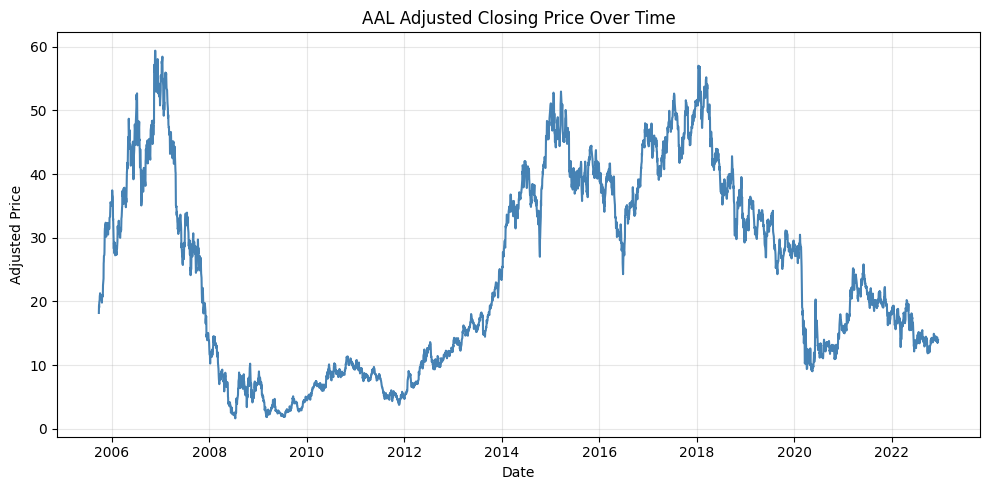

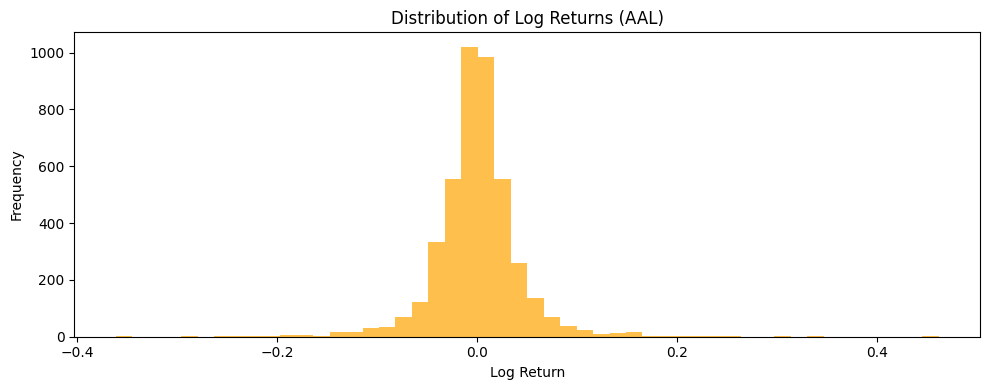

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Adjusted Closing Price over time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], color='steelblue')
plt.title("AAL Adjusted Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute and plot daily returns
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log1p(df['Return'])

# Plot histogram of log returns
plt.figure(figsize=(10, 4))
plt.hist(df['LogReturn'].dropna(), bins=50, color='orange', alpha=0.7)
plt.title("Distribution of Log Returns (AAL)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform 'Close' and 'Volume'
scaled_values = scaler.fit_transform(df[['Close', 'Volume']])

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_values, columns=['Close', 'Volume'], index=df.index)

print(" Scaled data preview:")
print(scaled_df.head())

# Optional: quick comparison before/after scaling
print("\nOriginal 'Close' mean/std:", df['Close'].mean(), df['Close'].std())
print("Scaled 'Close' mean/std:", scaled_df['Close'].mean(), scaled_df['Close'].std())


 Scaled data preview:
               Close    Volume
Date                          
2005-09-27 -0.410330 -0.610785
2005-09-28 -0.336070 -0.392870
2005-09-29 -0.354017 -0.605458
2005-09-30 -0.304510 -0.512355
2005-10-03 -0.274188 -0.606382

Original 'Close' mean/std: 24.446004507587325 15.236068483486637
Scaled 'Close' mean/std: 1.0494976941760077e-16 1.000115413469138


In [13]:
import numpy as np

def create_windows(data: np.ndarray, seq_len: int = 60):
    """
    Create overlapping input/output windows for time series forecasting.

    Parameters
    ----------
    data : np.ndarray
        Scaled data array of shape (num_timesteps, num_features)
        e.g., columns = ['Close', 'Volume']
    seq_len : int
        Length of each input sequence (number of timesteps)

    Returns
    -------
    X : np.ndarray
        Input sequences of shape (num_samples, seq_len, num_features)
    y : np.ndarray
        Target values (next-step Close) of shape (num_samples,)
    """
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 0])  # predict next-step Close value
    return np.array(X), np.array(y)

# Example usage
SEQ_LEN = 60
X, y = create_windows(scaled_df.values, SEQ_LEN)

print(f" Created input windows successfully!")
print(f"X shape: {X.shape}  --> (samples, sequence_length, features)")
print(f"y shape: {y.shape}  --> (samples,)")


 Created input windows successfully!
X shape: (4273, 60, 2)  --> (samples, sequence_length, features)
y shape: (4273,)  --> (samples,)


In [14]:
# Time-aware train/test split (no shuffling)
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(" Data split complete (time-aware, no shuffle)")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Sequence length: {X_train.shape[1]}")
print(f"Features per timestep: {X_train.shape[2]}")


 Data split complete (time-aware, no shuffle)
Train samples: 3418
Test samples: 855
Sequence length: 60
Features per timestep: 2


# Baseline Models — Persistence & Moving Average

Before training complex models (like Transformers), it’s important to establish baseline forecasts that represent simple, rule-based predictions.
These baselines help evaluate whether the neural network actually learns meaningful patterns or just replicates trivial behaviors.



# Interpretation of the “Baseline Forecast Comparison (Scaled Close)” Plot

This line plot compares the true scaled stock prices against two simple baseline forecasts:

Persistence (Naïve) model

Moving Average (5-day) model



---> **The Black Line — “True”**

This is the actual scaled closing price (y_test) of the stock during the test period.

The values are scaled, so they’re expressed in standard deviation units (around -1 to +1) instead of actual dollars.


---> **The Blue Line — “Persistence”**

The persistence model simply predicts that tomorrow’s price = today’s price.

Because short-term stock prices don’t change drastically day-to-day, this model tends to track the true series closely, with small delays where price changes rapidly.

---> **The Orange Line — “Moving Average (5)”**

The moving average model predicts the next price as the average of the past 5 closing prices.

This results in a smoother curve — it follows the general trend of the true price but lags slightly during sharp upturns or downturns.

---> **Overall Observation**

Both baseline predictions (blue and orange) closely follow the true price trend, showing that:

Short-term stock price movements are highly autocorrelated.

Even simple baselines can capture general market direction.

However, during more volatile periods (like around index 150–180 in your plot), both baselines lag behind or overshoot slightly, especially the moving average model — this shows their limitation in adapting to sudden changes.

 Baseline Model Performance (Scaled Close)
Persistence → MAE: 0.0327, RMSE: 0.0461
Moving Avg  → MAE: 0.0376, RMSE: 0.0532


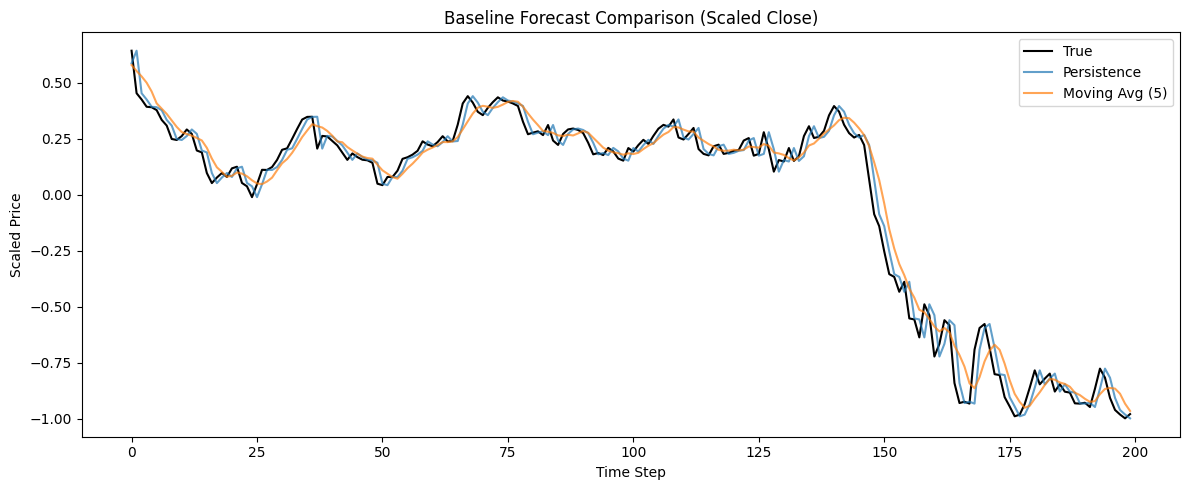

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# ---  PERSISTENCE baseline ---
persistence_pred = scaled_df['Close'].shift(1)
y_pred_persistence = persistence_pred[-len(y_test):].values

mae_persistence = mean_absolute_error(y_test, y_pred_persistence)
rmse_persistence = mean_squared_error(y_test, y_pred_persistence) ** 0.5  # fixed

# ---  MOVING AVERAGE baseline ---
def moving_average(series: pd.Series, window: int = 5):
    return series.rolling(window=window).mean()

ma_series = moving_average(scaled_df['Close'], window=5)
y_pred_ma = ma_series[-len(y_test):].values

mae_ma = mean_absolute_error(y_test, y_pred_ma)
rmse_ma = mean_squared_error(y_test, y_pred_ma) ** 0.5  # fixed

# ---  Results ---
print(" Baseline Model Performance (Scaled Close)")
print(f"Persistence → MAE: {mae_persistence:.4f}, RMSE: {rmse_persistence:.4f}")
print(f"Moving Avg  → MAE: {mae_ma:.4f}, RMSE: {rmse_ma:.4f}")

# ---  Visual Plot ---
n = min(200, len(y_test))
plt.figure(figsize=(12, 5))
plt.plot(y_test[:n], label="True", color='black')
plt.plot(y_pred_persistence[:n], label="Persistence", alpha=0.7)
plt.plot(y_pred_ma[:n], label="Moving Avg (5)", alpha=0.7)
plt.title("Baseline Forecast Comparison (Scaled Close)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Price")
plt.legend()
plt.tight_layout()
plt.show()
